# Sparse Gaussian Precision Matirx

A Gaussian graphical model (GGM) is a probabilistic graphical model used for modeling multivariate data. It represents the dependencies between random variables using a graph structure and employs Gaussian distributions to describe the conditional dependencies between the variables. In a Gaussian graphical model, each node represents a random variable, and the edges denote the correlations between them.
Gaussian graphical models find various applications in practical domains, including but not limited to:

- Biological and medical research: Gaussian graphical models are applied in analyzing gene expression data, functional brain network analysis, etc., helping understand the interactions between genes, proteins, and disease mechanisms.

- Signal processing: Gaussian graphical models are used for image processing, speech recognition, and other fields to model and analyze complex signals.

The learning process of a Gaussian graphical model can be achieved through maximum likelihood estimation, where a loss function is used to measure the goodness of fit of the model. This loss function is called the negative log-likelihood function (NLL) for Gaussian graphical models, defined as

$$L^{\text{GGM}}(\Omega)=\text{tr}(S\Omega)-\log\det \Omega.$$

where $\Omega$ represents the precision matrix (the inverse of the covariance matrix), and $S$ is the sample covariance matrix based on the available data.
Next, let's consider the optimization problem

$$
\begin{aligned}
\arg\min & L^{\text{GGM}}(\Omega),
\\
&\text{subject to:} \; 
\Omega \in \mathcal{S}^{++}, \\
&\qquad\qquad\| \Omega \|_0 \leq s ,\\
\end{aligned}
$$
where $\mathcal{S}^{++}$ is the set of positive definite matrices and $\| \Omega \|_0$ is the $L_0$ norm of the matrix $\Omega$.

For more information about Gaussian graphical models, please refer to Chapter 17 of [[1]](#refer-anchor-1).

In [1]:
from scope import GraspSolver, ScopeSolver
import jax.numpy as jnp
import numpy as np
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.covariance import GraphicalLassoCV#, ledoit_wolf
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import networkx as nx
import scipy.linalg as la
import warnings

warnings.filterwarnings("ignore", message="invalid value encountered in subtract")

Let's set the sample size n=150 and dimension p=30. 

1. **We first consider a graph structure where each pair of points is connected with a fixed probability.**

We will construct a symmetric positive definite precision matrix and generate samples from a corresponding multivariate Gaussian distribution.

In [2]:
n, p = 150, 30
prng = np.random.RandomState(1)
prec = make_sparse_spd_matrix(p, alpha=0.98, smallest_coef=0.3, largest_coef=0.5, random_state=prng)
cov = np.linalg.inv(prec)
d = np.sqrt(np.diag(cov))
cov /= d
cov /= d[:, np.newaxis]
prec *= d
prec *= d[:, np.newaxis]
X = prng.multivariate_normal(np.zeros(p), cov, size=n)
X -= X.mean(axis=0)
X /= X.std(axis=0)

# sample covariance and precision matrix
cov_sample = np.cov(X.T)
prec_sample = np.linalg.inv(cov_sample)

The network corresponding to this graph structure is as follows:

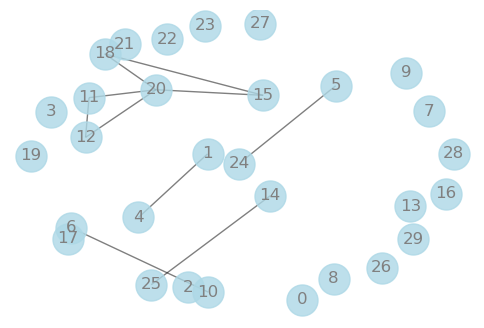

In [3]:
# Create the network
graph = nx.Graph()
for i in range(len(prec)):
    graph.add_node(i)
for i in range(len(prec)):
    for j in range(i + 1, len(prec)):
        if prec[i][j]:
            graph.add_edge(i, j)
            
# Set and show the network
np.random.seed(10)
pos = nx.spring_layout(graph, k=1)
plt.figure(figsize=(6, 4))
nx.draw_networkx_nodes(graph, pos, node_size=500, alpha=0.8, node_color='lightblue')
nx.draw_networkx_edges(graph, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(graph, pos, font_size=12, font_color='grey')
plt.axis('off')
plt.show()

Next, we define the loss function for the Gaussian graphical model and use the cvxpy package to enforce the constraint that the obtained matrix is symmetric positive definite.

In [4]:
def graphical_guassian_loss(params, sample_covariance_matrix):
    p = sample_covariance_matrix.shape[0]
    Omega = jnp.zeros((p, p))
    Omega = Omega.at[np.triu_indices(p)].set(params)
    Omega = jnp.where(Omega, Omega, Omega.T)
    return jnp.trace(jnp.matmul(sample_covariance_matrix, Omega)) - jnp.linalg.slogdet(Omega)[1]


def convex_solver_cvxpy(
    loss_fn,
    value_and_grad,
    params,
    optim_variable_set,
    data,
):
    data = np.squeeze(np.array(data))
    p = data.shape[1]
    dim = int(p * (p + 1) / 2)
    s = len(optim_variable_set)

    non_opt_mark_vec = np.ones(dim, dtype=bool)
    non_opt_mark_vec[optim_variable_set] = False
    non_opt_indices_mat = (
        np.triu_indices(p)[0][non_opt_mark_vec],
        np.triu_indices(p)[1][non_opt_mark_vec],
    )

    Omega = cp.Variable((p, p), PSD=True)

    constraints = [
        Omega[non_opt_indices_mat] == np.zeros(dim - s),
    ]

    graphical_guassian_loss = cp.trace(data @ Omega) - cp.log_det(Omega)

    prob = cp.Problem(cp.Minimize(graphical_guassian_loss), constraints)
    prob.solve()

    return graphical_guassian_loss.value, Omega.value[np.triu_indices(p)]

Then, we use `scope` to minimize the loss function under the constraint of $L_0$ regularization in order to obtain the scope estimate of the precision matrix.

In [5]:
solver = ScopeSolver(
    dimensionality=int(p * (p + 1) / 2),
    sparsity=np.count_nonzero(prec[np.triu_indices(p)]),
    always_select=np.where(np.triu_indices(p)[0] == np.triu_indices(p)[1])[0],
    numeric_solver=convex_solver_cvxpy,
)

solver.solve(
    graphical_guassian_loss,
    cov_sample,
    init_params=np.eye(p)[np.triu_indices(p)],
)

prec_scope = np.zeros((p, p))
prec_scope[np.triu_indices(p)] = solver.params
prec_scope = np.where(
    prec_scope, prec_scope, prec_scope.T
)

Graphical Lasso (glasso) [[2]](#refer-anchor-2) is a well-known method that minimizes the negative log-likelihood (NLL) with certain conditions or added penalty terms. It aims to optimize the problem expressed as $\text{tr}(S\Omega)-\log\det \Omega+\lambda\|\Omega\|_1$, where $\|\cdot\|_1$ represents the $L_1$-norm of the matrix.
In the next step, we will use glasso to handle this dataset, and the regularization parameter $\lambda$ will be selected by cross-validation (cv).

In [6]:
glCV_model = GraphicalLassoCV().fit(X)
prec_glCV = glCV_model.precision_

Next, we will demonstrate the differences between the estimated values and the actual values in terms of the Frobenius norm. Additionally, we will showcase the matrix heatmaps for the matrices.

In [7]:
print('Scope: ', np.linalg.norm(prec - prec_scope, ord='fro'))
print('Grapical Lasso: ', np.linalg.norm(prec - prec_glCV, ord='fro'))
print('Empirical: ', np.linalg.norm(prec - prec_sample, ord='fro')) 

Scope:  0.8424334289526428
Grapical Lasso:  1.082457024665967
Empirical:  4.371079632473682


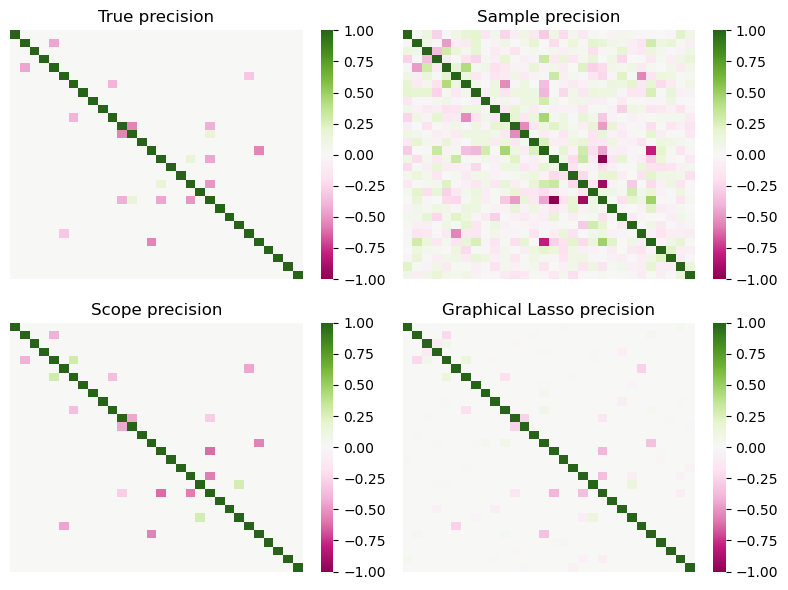

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
cmap = cm.PiYG

sns.heatmap(prec, vmin=-1, vmax=1, cmap=cmap, ax=axes[0, 0])
axes[0, 0].set_xticks([])
axes[0, 0].set_yticks([])
axes[0, 0].set_title('True precision')

sns.heatmap(prec_sample, vmin=-1, vmax=1, cmap=cmap, ax=axes[0, 1])
axes[0, 1].set_xticks([])
axes[0, 1].set_yticks([])
axes[0, 1].set_title('Sample precision')

sns.heatmap(prec_scope, vmin=-1, vmax=1, cmap=cmap, ax=axes[1, 0])
axes[1, 0].set_xticks([])
axes[1, 0].set_yticks([])
axes[1, 0].set_title('Scope precision')

sns.heatmap(prec_glCV, vmin=-1, vmax=1, cmap=cmap, ax=axes[1, 1])
axes[1, 1].set_xticks([])
axes[1, 1].set_yticks([])
axes[1, 1].set_title('Graphical Lasso precision')

plt.tight_layout()
plt.show()

The figure above presents matrix heatmaps of the actual precision matrix, sample precision matrix, scope estimator, and glasso estimator. The white portions represent zeros in the matrix, while the green and pink regions form the support set of the matrix. From the results, it can be observed that the scope estimator not only has fewer errors in selecting the support set but also exhibits smaller errors between its estimated values and the ground truth. Additionally, the figure indicates that the two positions where the scope estimator made mistakes also show some signal in the sample precision matrix and the glasso estimator.

2. **Next, we will consider the graph structure associated with a random vector where some variables form a Markov chain.**

A Markov chain is a mathematical model that describes a stochastic process where the current state depends only on the previous state. In other words, given the current state, the past states are irrelevant to the future evolution, and only the current state influences the future states. This property is known as "memorylessness" or the Markov property.

Markov chains have numerous applications in real-life scenarios. Here are a few examples:

- Weather prediction: Weather changes can often be modeled as a Markov chain. The weather state of each day is only dependent on the weather state of the previous day and is unaffected by earlier weather conditions. For instance, if today is sunny, tomorrow's weather could be sunny, cloudy, or rainy, with transition probabilities derived from historical data.

- Stock market analysis: Stock price fluctuations can be viewed as a Markov chain. The price at each moment depends solely on the previous price and is independent of earlier prices. Investors can leverage the Markov chain properties to forecast future price trends.

First, we define a function that generates a desired symmetric positive definite matrix.

In [9]:
def sparse_spd_matrix(p, s, model=0, u=10, v=1):
    # Create a zero matrix
    matrix = np.zeros((p, p))

    # Set diagonal elements
    np.fill_diagonal(matrix, 1)
    
    if model == 0:
        # Set elements at positions (i-1, i) and (i, i+1)
        np.fill_diagonal(matrix[1:, :s], u)
        np.fill_diagonal(matrix[:s, 1:], u)
    elif model == 1:
        # Set elements at positions (0, i) and (i, 0)
        matrix[0, :s] = u
        matrix[:s, 0] = u

    # Calculate the minimum eigenvalue
    eigenvalues = la.eigvalsh(matrix)
    lambda_min = np.min(eigenvalues)

    if lambda_min < 0:
        # Adjust the matrix if the minimum eigenvalue is less than 0
        adjustment = abs(lambda_min) + v
        matrix += adjustment * np.eye(p)
    matrix *= u
        
    # Check if the matrix is positive definite using Cholesky decomposition
    try:
        cholesky = la.cholesky(matrix)
    except la.LinAlgError:
        raise ValueError("The generated matrix is not positive definite!")

    return matrix

Below, we similarly construct a sample and display the actual network graph corresponding to the sample. 
Then, we use the `ScopeSolver` from the `scope` package and `glasso` from `sklearn` to process the data in a similar manner. 
We compare the Frobenius norm of the difference between the estimated values and the true values. 
After that, we display the matrix heatmaps of the true precision matrix, the sample precision matrix, and the precision matrix obtained from the estimation.

In [10]:
n, p, s = 150, 30, 10
prec = sparse_spd_matrix(p, s, model = 0)
cov = np.linalg.inv(prec)
d = np.sqrt(np.diag(cov))
cov /= d
cov /= d[:, np.newaxis]
prec *= d
prec *= d[:, np.newaxis]
X = prng.multivariate_normal(np.zeros(p), cov, size=n)
X -= X.mean(axis=0)
X /= X.std(axis=0)

# sample covariance and precision matrix
cov_sample = np.cov(X.T)
prec_sample = np.linalg.inv(cov_sample)

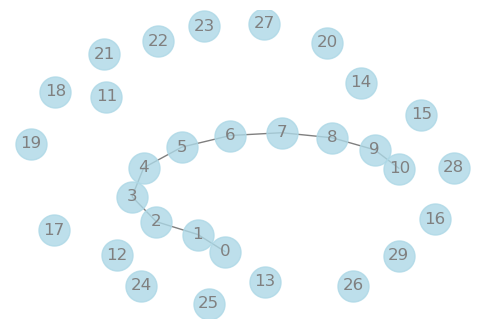

In [11]:
# Create the network
graph = nx.Graph()
for i in range(len(prec)):
    graph.add_node(i)
for i in range(len(prec)):
    for j in range(i + 1, len(prec)):
        if prec[i][j]:
            graph.add_edge(i, j)
            
# Set and show the network
np.random.seed(10)
pos = nx.spring_layout(graph, k=0.4)
plt.figure(figsize=(6, 4))
nx.draw_networkx_nodes(graph, pos, node_size=500, alpha=0.8, node_color='lightblue')
nx.draw_networkx_edges(graph, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(graph, pos, font_size=12, font_color='grey')
plt.axis('off')
plt.show()

In [12]:
solver = ScopeSolver(
    dimensionality=int(p * (p + 1) / 2),
    sparsity=np.count_nonzero(prec[np.triu_indices(p)]),
    always_select=np.where(np.triu_indices(p)[0] == np.triu_indices(p)[1])[0],
    numeric_solver=convex_solver_cvxpy,
)

solver.solve(
    graphical_guassian_loss,
    cov_sample,
    init_params=np.eye(p)[np.triu_indices(p)],
)

prec_scope = np.zeros((p, p))
prec_scope[np.triu_indices(p)] = solver.params
prec_scope = np.where(
    prec_scope, prec_scope, prec_scope.T
)

In [13]:
glCV_model = GraphicalLassoCV().fit(X)
prec_glCV = glCV_model.precision_

In [14]:
print('Scope: ', np.linalg.norm(prec - prec_scope, ord='fro'))
print('Grapical Lasso cv: ', np.linalg.norm(prec - prec_glCV, ord='fro'))
print('Empirical: ', np.linalg.norm(prec - prec_sample, ord='fro')) 

Scope:  2.0997022780325714
Grapical Lasso cv:  5.743418197049865
Empirical:  6.907197094774609


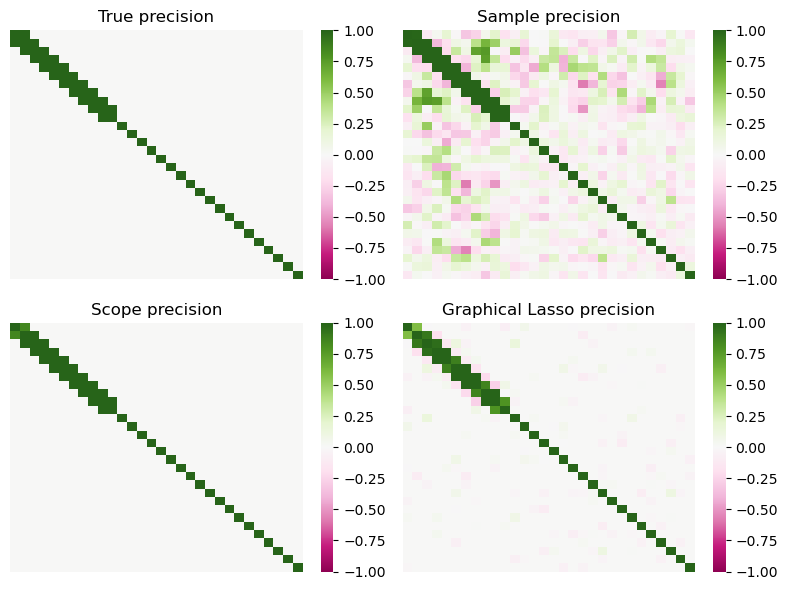

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
cmap = cm.PiYG

sns.heatmap(prec, vmin=-1, vmax=1, cmap=cmap, ax=axes[0, 0])
axes[0, 0].set_xticks([])
axes[0, 0].set_yticks([])
axes[0, 0].set_title('True precision')

sns.heatmap(prec_sample, vmin=-1, vmax=1, cmap=cmap, ax=axes[0, 1])
axes[0, 1].set_xticks([])
axes[0, 1].set_yticks([])
axes[0, 1].set_title('Sample precision')

sns.heatmap(prec_scope, vmin=-1, vmax=1, cmap=cmap, ax=axes[1, 0])
axes[1, 0].set_xticks([])
axes[1, 0].set_yticks([])
axes[1, 0].set_title('Scope precision')

sns.heatmap(prec_glCV, vmin=-1, vmax=1, cmap=cmap, ax=axes[1, 1])
axes[1, 1].set_xticks([])
axes[1, 1].set_yticks([])
axes[1, 1].set_title('Graphical Lasso precision')

plt.tight_layout()
plt.show()

The results indicate that the scope estimator accurately identifies the appropriate support set, and the estimated values have minimal deviation from the actual values.

3. **Next, we consider a graph structure that includes a hub node.**

In graph theory, hub nodes refer to nodes that have high connectivity with other nodes. These nodes typically have a higher number of edges, serving as the core or central nodes in the network.
The importance of hub nodes lies in their critical role in the structure and functionality of the entire network. Here are some examples of where hub nodes may exist in practical scenarios:

- Social Networks: In social media platforms, individuals with a large number of followers or fans, such as influencers, celebrities, or public figures, act as hub nodes. They can influence the network by sharing information, shaping public opinion, and spreading ideas.

- Transportation Networks: In road, air, or rail networks, hub cities or transportation hubs often serve as hub nodes. These locations play a crucial role in connecting different regions, routes, or segments, facilitating the flow of people and goods.

We use the same method as mentioned above to construct and process the sample.

In [16]:
n, p, s = 150, 30, 10
prec = sparse_spd_matrix(p, s, model = 1)
cov = np.linalg.inv(prec)
d = np.sqrt(np.diag(cov))
cov /= d
cov /= d[:, np.newaxis]
prec *= d
prec *= d[:, np.newaxis]
X = prng.multivariate_normal(np.zeros(p), cov, size=n)
X -= X.mean(axis=0)
X /= X.std(axis=0)

# sample covariance and precision matrix
cov_sample = np.cov(X.T)
prec_sample = np.linalg.inv(cov_sample)

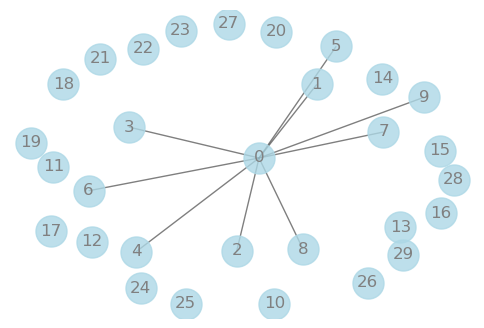

In [17]:
# Create the network
graph = nx.Graph()
for i in range(len(prec)):
    graph.add_node(i)
for i in range(len(prec)):
    for j in range(i + 1, len(prec)):
        if prec[i][j]:
            graph.add_edge(i, j)
            
# Set and show the network
np.random.seed(10)
pos = nx.spring_layout(graph, k=1)
plt.figure(figsize=(6, 4))
nx.draw_networkx_nodes(graph, pos, node_size=500, alpha=0.8, node_color='lightblue')
nx.draw_networkx_edges(graph, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(graph, pos, font_size=12, font_color='grey')
plt.axis('off')
plt.show()

In [18]:
solver = ScopeSolver(
    dimensionality=int(p * (p + 1) / 2),
    sparsity=np.count_nonzero(prec[np.triu_indices(p)]),
    always_select=np.where(np.triu_indices(p)[0] == np.triu_indices(p)[1])[0],
    numeric_solver=convex_solver_cvxpy,
)

solver.solve(
    graphical_guassian_loss,
    cov_sample,
    init_params=np.eye(p)[np.triu_indices(p)],
)

prec_scope = np.zeros((p, p))
prec_scope[np.triu_indices(p)] = solver.params
prec_scope = np.where(
    prec_scope, prec_scope, prec_scope.T
)

In [19]:
glCV_model = GraphicalLassoCV().fit(X)
prec_glCV = glCV_model.precision_

In [20]:
print('Scope: ', np.linalg.norm(prec - prec_scope, ord='fro'))
print('Grapical Lasso cv: ', np.linalg.norm(prec - prec_glCV, ord='fro'))
print('Empirical: ', np.linalg.norm(prec - prec_sample, ord='fro')) 

Scope:  1.967546610271899
Grapical Lasso cv:  13.679067574605002
Empirical:  9.30772280820012


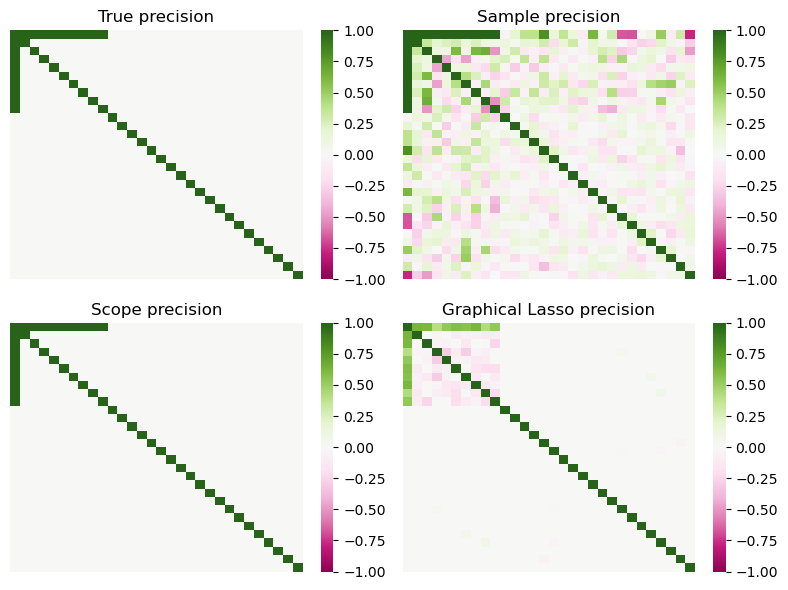

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
cmap = cm.PiYG

sns.heatmap(prec, vmin=-1, vmax=1, cmap=cmap, ax=axes[0, 0])
axes[0, 0].set_xticks([])
axes[0, 0].set_yticks([])
axes[0, 0].set_title('True precision')

sns.heatmap(prec_sample, vmin=-1, vmax=1, cmap=cmap, ax=axes[0, 1])
axes[0, 1].set_xticks([])
axes[0, 1].set_yticks([])
axes[0, 1].set_title('Sample precision')

sns.heatmap(prec_scope, vmin=-1, vmax=1, cmap=cmap, ax=axes[1, 0])
axes[1, 0].set_xticks([])
axes[1, 0].set_yticks([])
axes[1, 0].set_title('Scope precision')

sns.heatmap(prec_glCV, vmin=-1, vmax=1, cmap=cmap, ax=axes[1, 1])
axes[1, 1].set_xticks([])
axes[1, 1].set_yticks([])
axes[1, 1].set_title('Graphical Lasso precision')

plt.tight_layout()
plt.show()

Based on the results, it is evident that the scope estimator performs well in identifying the correct support set, resulting in estimations that closely align with the actual values and exhibit minimal errors.

### Reference

<div id="refer-anchor-1"></div>

- [1] Hastie, T., Tibshirani, R., Friedman, J. H., & Friedman, J. H. (2009). The elements of statistical learning: data mining, inference, and prediction (Vol. 2, pp. 1-758). New York: springer.

<div id="refer-anchor-2"></div>

- [2] Friedman, J., Hastie, T., & Tibshirani, R. (2008). Sparse inverse covariance estimation with the graphical lasso. Biostatistics, 9(3), 432-441.